In [47]:
### this script reads yolo labels, and compares gt distance to monodepth distance
import glob
import numpy as np
import os
from tqdm import tqdm


GT_PATH = r'C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\Cityscapes-Sequence\disparity_sequence_trainvaltest\gt_depth'
gt_labels = glob.glob(GT_PATH+'\*.npy')

MONO_PATH = r'C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\Cityscapes-Dataset\monodepth\cityscapes_prediction\low'
mono_predictions = glob.glob(MONO_PATH +'\*.npy')

labels = r'C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\yolov5\yolov5-master\runs\detect\low_quality\labels'
labels = glob.glob(labels+'\*.txt')

In [49]:
def unconvert(class_id, width, height, x, y, w, h):
    '''unconvert yolo coordinates to absolyte bounding box coordinates'''

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    class_id = int(class_id)
    return class_id, xmin, xmax, ymin, ymax

filename = []
y_true = []
y_pred = []
object_id = []
bbox = []
o_width = []
o_height = []

#image height and with
width = 2048
height = 1024

#for each file in predicted labels
for file in tqdm(labels):
    label_norm = np.loadtxt(file).reshape(-1, 5)
    
    basename = os.path.basename(file)  #basename of the file
    basename_no_ext = os.path.splitext(basename)[0][:-4]
    
    
    for i in range(len(label_norm)):  #for each label in the txt file
        labels_conv = label_norm[i]
        class_id, xmin, xmax, ymin, ymax = unconvert(labels_conv[0], width, height, labels_conv[1], labels_conv[2], labels_conv[3], labels_conv[4])
        
        o_width.append(xmax-xmin)
        o_height.append(ymax-ymin)
        object_id.append(class_id) #save class id
        bbox.append([xmin,xmax,ymin,ymax]) #save object width
        filename.append(basename_no_ext + "_leftImg8bit.png") #save filename

    #find corresponding ground truth file
                
        gt = os.path.join(GT_PATH,'{}_disparity.npy'.format(basename_no_ext))      
        object_gt = np.load(gt)
        y_true.append(np.median(object_gt[ymin:ymax,xmin:xmax]))

                
        mono = os.path.join(MONO_PATH, '{}_low_mono.npy'.format(basename_no_ext))
        object_mono = np.load(mono)
        y_pred.append(np.median(object_mono[ymin:ymax,xmin:xmax]))
                

100%|██████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:46<00:00, 28.64it/s]


In [50]:
### validate the prediction
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


#create dataframe with filename, object id, true values, prediction values and object width+height
data = {'filename': filename,
       'object_id': object_id,
       'y_true': y_true,
       'bbox': bbox,
       'y_pred': y_pred,
       'o_width': o_width,
       'o_height': o_height}

df = pd.DataFrame(data=data)
# df = df[::30] #remove all values that larger than 100m
df = df[df.y_true < 60.0]


#remove traffic signs that are not traffic signs based on their measurements
wrong_size = df[ (df.object_id == 0) & (df.o_width > 2*df.o_height) ].index
also_wrong_size = df[ (df.object_id == 0) & (df.o_height > 2*df.o_width) ].index

print('old amount of objects', len(df))

df.drop(wrong_size, inplace=True)
df.drop(also_wrong_size, inplace=True)

print('new amount of object', len(df))


df['y_pred'] = df['y_pred'].transform(func=lambda x: np.round(x,3))
df['y_true'] = df['y_true'].transform(func=lambda x: np.round(x,3))

df.head()

old amount of objects 3351
new amount of object 3133


,filename,object_id,y_true,bbox,y_pred,o_width,o_height
0,bonn_000000_000001_leftImg8bit.png,0,36.79,"[1141, 1169, 350, 374]",1.637,28,24
1,bonn_000000_000002_leftImg8bit.png,0,35.66,"[1145, 1172, 346, 372]",1.747,27,26
2,bonn_000000_000008_leftImg8bit.png,0,30.04,"[1190, 1220, 288, 319]",1.523,30,31
3,bonn_000000_000009_leftImg8bit.png,0,29.61,"[1196, 1227, 284, 316]",1.621,31,32
4,bonn_000000_000012_leftImg8bit.png,0,26.37,"[1227, 1262, 267, 301]",1.068,35,34


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE

# df=pd.read_csv('monodepth_predictions_valset.csv')

#gridsearch
true_vals = list(df.y_true)

#find value which minimizes MSE
grid = []
for i in np.linspace(20, 30, 200, endpoint = False):
    predictions = list(df.y_pred)
    pred_vals = [i*val for val in predictions]
    
    grid.append((np.round(MAE(true_vals,pred_vals),2),i))
        
scale_factor = min(grid) #28.06

scale_factor = 28.06
# print(scale_factor)

# predictions = list(df.y_pred)
# #scaled_vals = [scale_factor*val for val in predictions]

# df['y_pred'] = [scale_factor*val for val in predictions]

df['y_pred'] = df['y_pred'].transform(func=lambda x: x*scale_factor)

df.to_json('monodepth_predictions_low.json')

print(np.round(MAE(df.y_true , df.y_pred)))
df.head()
print(scale_factor)

9.0
28.06


In [177]:
pkl = r'C:\Users\portierl4527\ARCADIS\Afstuderen Levi - Depth estimation - General\Cityscapes-Dataset\triangulation\bonn.pkl'

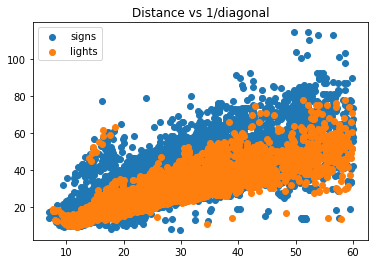

<Figure size 432x288 with 0 Axes>

In [208]:
width = df.o_width
height = df.o_height

width2 = width*width
height2 = height*height

diagonal = np.sqrt(width2+height2)
df['diagonal'] = diagonal #2289


#### create some plots
import matplotlib.pyplot as plt
import math

signs  = df[df['object_id'] == 0]
lights = df[df['object_id'] == 1]

#plt.scatter(x=df.o_height, y=df.absolute_error)
plt.scatter(x=signs.y_true, y=1/(signs.diagonal/2289), label='signs')
plt.scatter(x=lights.y_true, y=1/(lights.diagonal/2289), label = 'lights')
plt.title('Distance vs 1/diagonal')
plt.legend()
plt.show()
plt.savefig("distance-diagonal.png")

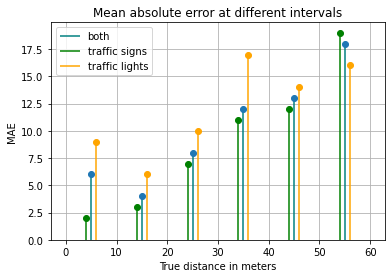

In [52]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

errors = []
errors_light = []
errors_sign = []


signs  = df[df['object_id'] == 0]
lights = df[df['object_id'] == 1]

#all
for i in range(0,51,10):
    interval = df[(df.y_true >= i ) & (df.y_true < i+10)]
    
    y_pred = interval.y_pred
    err = np.round(MAE(interval.y_true, y_pred ))
    
    errors.append(err)

for i in range(0,51,10):
    interval = signs[(signs.y_true >= i ) & (signs.y_true < i+10)]
    
   
    y_pred = interval.y_pred
    
    err = np.round(MAE(interval.y_true, y_pred ))
    
    errors_sign.append(err)

for i in range(0,51,10):
    interval = lights[(lights.y_true >= i ) & (lights.y_true < i+10)]
    
   
    
    y_pred = interval.y_pred
    
    err = np.round(MAE(interval.y_true, y_pred ))
    
    errors_light.append(err)
    
    
    
fig, ax = plt.subplots()  
ax.vlines(range(5,56,10),ymax=errors,label ='both', color='teal', ymin=0)  
ax.plot(range(5,56,10),errors,'o')  

ax.vlines(range(4,55,10),ymax=errors_sign, label ='traffic signs', color='green', ymin=0)
ax.plot(range(4,55,10),errors_sign,'o', color='green')  

ax.vlines(range(6,57,10),ymax=errors_light, label ='traffic lights',color='orange', ymin=0)
ax.plot(range(6,57,10),errors_light,'o', color='orange')  

ax.grid(True)
ax.xaxis.set_data_interval(0 , 60)
ax.set_ylim(0)

plt.title('Mean absolute error at different intervals')
plt.xlabel('True distance in meters')
plt.ylabel('MAE')
plt.legend()
plt.savefig('monodepthMAE.png')
plt.show()

In [167]:
THRESHOLD = 1



############all
count = 0
for i in range(len(df)):
    if abs(df.y_true.iloc[i] - df.y_pred.iloc[i]) <= THRESHOLD:
        count += 1
percentage = count/len(df)*100

print(np.round(percentage,2), '% of predictions are within', THRESHOLD, 'meters of true value.')

signs = df[df.object_id == 0]
lights = df[df.object_id == 1] 

count = 0
for i in range(len(signs)):
    if abs(signs.y_true.iloc[i] - signs.y_pred.iloc[i]) <= THRESHOLD:
        count += 1
percentage = count/len(signs)*100

print(np.round(percentage,2), '% of traffic sign predictions are within', THRESHOLD, 'meters of true value.')

########lights

count = 0
for i in range(len(lights)):
    if abs(lights.y_true.iloc[i] - lights.y_pred.iloc[i]) <= THRESHOLD:
        count += 1
percentage = count/len(lights)*100

print(np.round(percentage,2), '% of traffic light predictions are within', THRESHOLD, 'meters of true value.')

7.55 % of predictions are within 1 meters of true value.
7.95 % of traffic sign predictions are within 1 meters of true value.
6.82 % of traffic light predictions are within 1 meters of true value.
